In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import datetime
import seaborn as sns

In [26]:
import dwave
from dwave.cloud import Client
client = Client.from_config(config_file= '/home/rajarsi/.config/dwave/dwave.conf' )
dwave.cloud.config.load_config(['/home/rajarsi/.config/dwave/dwave.conf'])
import dimod
import neal
from dwave.system import LeapHybridCQMSampler, DWaveSampler , LeapHybridSampler, EmbeddingComposite
import dwave.inspector
from dimod import ExactCQMSolver, ExactDQMSolver, ExactSolver
from dimod import BinaryQuadraticModel as BQM
from dimod import QuadraticModel as QM
from dimod import ConstrainedQuadraticModel as CQM


### Example: Portfolio Optmisation

In this example we will solve the Portfolio Optimisation problem using DWave annealers.

The basic portfolio optimisation task requires to pick an portfolio so as to minimise the risk and maximise the expected return, encode in the hamiltoninan as ,
$$      min_{\vec{x}} \sum_{ij} x_i C_{ij} x_j - \sum_{i} E_{i} x_i
$$
 where $C$ is the covariance matrix of the selected assets and the $E$ is the expected return of the assets

##### Getting Stock Data

In [5]:
def get_stock_data(stocks, start= datetime.datetime(2000,1,1) , end= datetime.datetime(2022,1,1) ) :
    """ Return stock data and covariace matrix corresponding to it """
    data = pd.DataFrame()
    for stock in stocks:
         data[stock] = pdr.DataReader(stock,data_source='yahoo', start= start, end= end)['Adj Close']

    rtrn_data = data/data.shift(1)
    rtrn_data =  np.log(rtrn_data[1:])
    cov_matrix = rtrn_data.cov()
    return rtrn_data, cov_matrix

<AxesSubplot:>

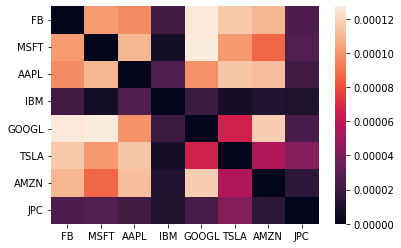

In [6]:
stocks= ['FB', 'MSFT', 'AAPL', 'IBM', 'GOOGL', 'TSLA', 'AMZN', 'JPC']
# stocks= ['FB', 'MSFT', 'AAPL']
data = get_stock_data(stocks)

cov_matrix = data[1]
mean_rtrn = data[0].mean()
for stock in stocks : cov_matrix[stock][stock] = 0
sns.heatmap(cov_matrix)

##### Setting up BQM

First we try to solve the problem using a BinaryQuadraticModel i.e the stock variables are binary $ x_i \in \{0,1\}$



In [16]:
bqm = BQM('BINARY')
for stock in stocks : bqm.add_variable(stock)

## prepare quadratic model corresponding to portfolio 
for stock in stocks: bqm.add_linear_from({stock: -1*mean_rtrn[stock]})
for stock_i in stocks :
    for stock_j in stocks : 
        if stock_i != stock_j: bqm.add_quadratic_from({(stock_i, stock_j): +1*cov_matrix[stock_i][stock_j] })
        
# bqm

We can directly solve the pprobelm using simulated annealing from ```neal.SimulatedAnnealingSampler```. 

In [8]:
##### Simulated Annealing solver
sampler = neal.SimulatedAnnealingSampler()
# sampler.properties, sampler.parameters
pf_op = sampler.sample(bqm, num_sweeps= 100, num_sweeps_per_beta= 50, num_reads= 10 ,beta_schedule= 'geometric' ,seed= 1234)
## most optimal solution 
pf_op.first


Sample(sample={'AAPL': 1, 'AMZN': 0, 'FB': 0, 'GOOGL': 1, 'IBM': 1, 'JPC': 0, 'MSFT': 1, 'TSLA': 1}, energy=-0.0069584300834686814, num_occurrences=1)

##### Setting up BQM with constraints (lagrange multiplier method)

Here we can also introduce inequality/equality constraints to our BQM. Here we introduce a  constraint such that the number of stocks selected is less than 4 i.e $ \sum_{i} x_i <= 4 $. Here the constraints are encoded into the obejctive function directly as a penalty by as $C_{obj}' = C_{obj} + \lambda (\sum_{i}x_i - 4 )^2 $,
scaled by an appropriate multiplier $\lambda$

In [17]:
bqm_vars = [dimod.Binary(var) for  var in bqm.variables]
constraint_sum = [(var, 1 ) for var in bqm.variables ] 
# constraint_min_rtnr = [(var, mean_rtrn[var]) for var in bqm.variables  ]

bqm.add_linear_inequality_constraint( constraint_sum, lagrange_multiplier= 10,  lb= 0, ub= 4, label= 'sum')
# bqm.add_linear_inequality_constraint( constraint_min_rtnr, lagrange_multiplier= 10,  lb= 0, ub= 5, label= 'sum')

[('slack_sum_0', 1), ('slack_sum_1', 2), ('slack_sum_2', 1)]

In [18]:
sample_set_bqm = ExactSolver().sample(bqm)
sample_set_bqm

SampleSet(rec.array([([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 160.        , 1),
           ([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  90.00317096, 1),
           ([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0],  40.0018218 , 1), ...,
           ([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],  10.0018218 , 1),
           ([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],  40.00317096, 1),
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],  90.        , 1)],
          dtype=[('sample', 'i1', (11,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), Variables(['AAPL', 'AMZN', 'FB', 'GOOGL', 'IBM', 'JPC', 'MSFT', 'TSLA', 'slack_sum_0', 'slack_sum_1', 'slack_sum_2']), {}, 'BINARY')

Note that the smaple-set obtained from the ```ExactSolver``` for the constrained BQM is not very good plus we have to tune the lagrange multipliers manually !

##### Setting up CQM

Here we use the ```ConstrainedQuadraticModel``` class of ```dimod``` to solve the same problem, here we have the advantage that the constrained are handled directly instead of being put into the objective function as a penlaty directly, which gives significant improvment in performance than the ```BinaryQuadraticModel```.

In [19]:
# dimod.REAL_INTERACTIONS = True
qm = QM()
for stock in stocks : qm.add_variable('BINARY',stock)

## prepare quadratic model corresponding to portfolio 
for stock in stocks: qm.add_linear_from({stock: -1*mean_rtrn[stock]})
for stock_i in stocks :
    for stock_j in stocks : 
        if stock_i != stock_j: qm.add_quadratic_from({(stock_i, stock_j): +1*cov_matrix[stock_i][stock_j] })
    
##### Setting up CQM from QM

cqm = CQM.from_qm(qm)

## add constriants to the model 

vars = cqm.variables
vars =  [dimod.Binary(var) for var in vars ]

cqm.add_constraint( sum(vars) <= len(vars) - 2, label= 'max stock constraint')

rtrns = []
for stock in range(len(vars)) :
    rtrns.append(mean_rtrn[stock]*vars[stock])
rtrn = sum(rtrns)
cqm.add_constraint( rtrn  >= 0, label= 'min return constraint' )

'min return constraint'

##### Using ExactSolver 

As before we first solve the problem using exact samplers, whihc for this case is ```ExactCQMSolver```.

In [20]:
pf_sample_set = ExactCQMSolver().sample_cqm(cqm)

In [21]:
pf_sample_set.first

Sample(sample={'AAPL': 1, 'AMZN': 0, 'FB': 0, 'GOOGL': 1, 'IBM': 1, 'JPC': 0, 'MSFT': 1, 'TSLA': 1}, energy=-0.0069584300834686814, num_occurrences=1, is_satisfied=array([ True,  True]), is_feasible=True)

##### Using 'INTEGER' variable type 

Next we reformulate the same model but using integer variables instead of binary variables as done in the previuos cases.

In [32]:
qm_int = QM()
for stock in stocks : qm_int.add_variable('INTEGER',stock, upper_bound = 5)

## prepare quadratic model corresponding to portfolio 
for stock in stocks: qm_int.add_linear_from({stock: -1*mean_rtrn[stock]})
for stock_i in stocks :
    for stock_j in stocks : 
        if stock_i != stock_j: qm_int.add_quadratic_from({(stock_i, stock_j): +1*cov_matrix[stock_i][stock_j] })

cqm_int = CQM.from_qm(qm_int)
# cqm_int.objective
vars = cqm_int.variables
vars =  [dimod.Integer(var, upper_bound = 5) for var in vars ] ## the upper-bound bounds the variable 

## add constraints
cqm_int.add_constraint( sum(vars) <= 20 , label= 'max stock constraint')

rtrns = []
for stock in range(len(vars)) :
    rtrns.append(mean_rtrn[stock]*vars[stock])
rtrn = sum(rtrns)
cqm_int.add_constraint( rtrn  >= 0.0001 , label= 'min return constraint' )        


'min return constraint'

In [33]:
pf_sample_set_int = ExactCQMSolver().sample_cqm(cqm_int)

In [39]:
pf_sample_set_int

(SampleSet(rec.array([([0, 0, 0, 0, 0, 0, 0, 0],  0.        , 1, [ True, False], False),
            ([0, 0, 0, 0, 0, 0, 1, 0], -0.00155113, 1, [ True,  True],  True),
            ([0, 0, 0, 0, 0, 0, 2, 0], -0.00310226, 1, [ True,  True],  True),
            ...,
            ([5, 5, 5, 5, 5, 5, 3, 5],  0.05776215, 1, [False,  True], False),
            ([5, 5, 5, 5, 5, 5, 4, 5],  0.06179816, 1, [False,  True], False),
            ([5, 5, 5, 5, 5, 5, 5, 5],  0.06583416, 1, [False,  True], False)],
           dtype=[('sample', '<i8', (8,)), ('energy', '<f8'), ('num_occurrences', '<i8'), ('is_satisfied', '?', (2,)), ('is_feasible', '?')]), Variables(['AAPL', 'AMZN', 'FB', 'GOOGL', 'IBM', 'JPC', 'MSFT', 'TSLA']), {'constraint_labels': ['max stock constraint', 'min return constraint']}, 'INTEGER'),
 Sample(sample={'AAPL': 5, 'AMZN': 0, 'FB': 0, 'GOOGL': 0, 'IBM': 0, 'JPC': 0, 'MSFT': 0, 'TSLA': 5}, energy=-0.021386527531152937, num_occurrences=1, is_satisfied=array([ True,  True]), is_feasi

In [40]:
pf_sample_set_int.first

Sample(sample={'AAPL': 5, 'AMZN': 0, 'FB': 0, 'GOOGL': 0, 'IBM': 0, 'JPC': 0, 'MSFT': 0, 'TSLA': 5}, energy=-0.021386527531152937, num_occurrences=1, is_satisfied=array([ True,  True]), is_feasible=True)

##### Using Leap's sampler

Here we use DWave's cloud based hybrid solver to sample the solutions !

In [37]:
sampler_cqm = LeapHybridCQMSampler()
sample_set_leap = sampler_cqm.sample_cqm(cqm)
sample_set_leap

SampleSet(rec.array([([1., 0., 0., 1., 1., 0., 1., 1.], -0.00695843, 1,  True, [ True,  True]),
           ([1., 0., 0., 1., 1., 0., 1., 1.], -0.00695843, 1,  True, [ True,  True]),
           ([1., 0., 0., 1., 1., 0., 1., 1.], -0.00695843, 1,  True, [ True,  True]),
           ([1., 0., 0., 1., 1., 0., 1., 1.], -0.00695843, 1,  True, [ True,  True]),
           ([1., 0., 0., 1., 1., 0., 1., 1.], -0.00695843, 1,  True, [ True,  True]),
           ([1., 0., 0., 1., 1., 0., 1., 1.], -0.00695843, 1,  True, [ True,  True]),
           ([1., 0., 0., 1., 1., 0., 1., 1.], -0.00695843, 1,  True, [ True,  True]),
           ([1., 0., 0., 1., 1., 0., 1., 1.], -0.00695843, 1,  True, [ True,  True]),
           ([1., 0., 0., 1., 1., 0., 1., 1.], -0.00695843, 1,  True, [ True,  True]),
           ([1., 0., 0., 1., 1., 0., 1., 1.], -0.00695843, 1,  True, [ True,  True]),
           ([1., 0., 0., 1., 1., 0., 1., 1.], -0.00695843, 1,  True, [ True,  True]),
           ([1., 0., 0., 1., 1., 0., 1., 1.]

In [41]:
sample_set_leap.first

Sample(sample={'AAPL': 1.0, 'AMZN': 0.0, 'FB': 0.0, 'GOOGL': 1.0, 'IBM': 1.0, 'JPC': 0.0, 'MSFT': 1.0, 'TSLA': 1.0}, energy=-0.006958430083468694, num_occurrences=1, is_feasible=True, is_satisfied=array([ True,  True]))

##### Using 'REAL' vartype in CQM

REAL type variables do not support interactions , only linear terms should be used in objective and constraints

### Example: Independet Set Problem

Here we solve the Maximum Independent Set problem. The aim is to select the largest set of vertices in a given graph such that none of the selected vertices are adjacent to each other.  

The objective function in this case is 
$$      \mathbf{C}(\mathbf{x}) =  \sum_{i \in nodes } - x_i
$$ which is simply the number of nodes selected.

However we also need to care about the constraint on adjacency,
$$      \sum_{(i,j) \in edges} x_i x_j  = 0
$$

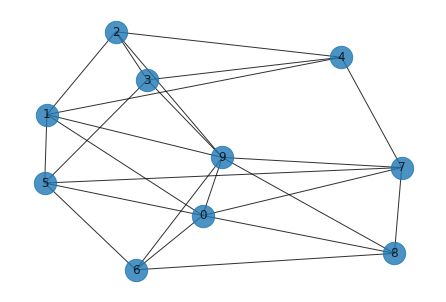

In [42]:
## initiate random graph~
import networkx as nx
from networkx import erdos_renyi_graph

nodes = 10
p = 0.5

rnd_graph = erdos_renyi_graph(nodes, p, seed= 1904892)
nx.draw(rnd_graph, with_labels= True, alpha= 0.8, node_size= 500)

Formulate a CQM for this problem

In [48]:
## create quadratic model form graph
graph_qm = QM()
for node in rnd_graph.nodes : graph_qm.add_variable('BINARY', str(node) )
for var in graph_qm.variables : graph_qm.add_linear_from({var: -1})     ## add the objective function

graph_cqm = CQM.from_qm(graph_qm)
graph_vars = [dimod.Binary(var) for var in graph_cqm.variables]

edge_sum = []
for edge in list(rnd_graph.edges):
    edge_sum.append(graph_vars[edge[0]]*graph_vars[edge[1]])
edge_sum = sum(edge_sum)

graph_cqm.add_constraint(edge_sum == 0, label= 'edge sum constraint')   ## add constraint on the edges


'edge sum constraint'

As before we solve the problem using both the ```ExactCQMSolver``` as well as the ```LeapHybridCQMSolver``` .

In [44]:
graph_sample_set = ExactCQMSolver().sample_cqm(graph_cqm)
df = graph_sample_set.to_pandas_dataframe()
df.sort_values(by=['energy'])
df = df.loc[df['is_satisfied']== True]
config = {}
for node in graph_cqm.variables :
     config[int(node)] = df.iloc[[-1]][node].to_numpy()[0]
nx.set_node_attributes(rnd_graph, name= 'color', values = config)

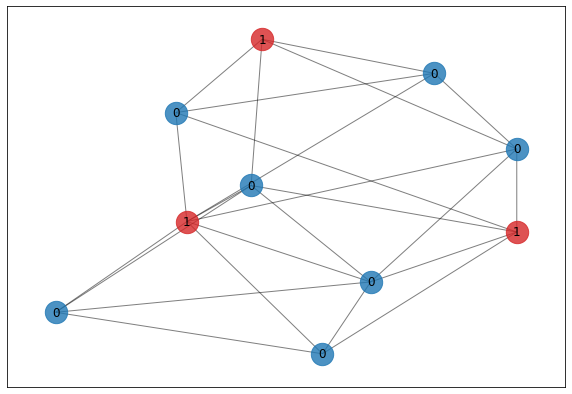

In [45]:
red = [node for node in rnd_graph.nodes() if rnd_graph.nodes()[node]['color'] == 1  ]
blue = [node for node in rnd_graph.nodes() if rnd_graph.nodes()[node]['color'] == 0  ]

plt.figure(figsize= (10,7))
pos = nx.spring_layout(rnd_graph)
nx.draw_networkx_nodes(rnd_graph,pos, nodelist= red, node_color= "tab:red",  alpha= 0.8, node_size= 500)
nx.draw_networkx_nodes(rnd_graph,pos, nodelist= blue, node_color= "tab:blue", alpha= 0.8, node_size= 500)
nx.draw_networkx_edges(rnd_graph,pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(rnd_graph, pos, config)
plt.show()

In [46]:
graph_sample_set = LeapHybridCQMSampler().sample_cqm(graph_cqm)
df = graph_sample_set.to_pandas_dataframe()
df.sort_values(by=['energy'])
df = df.loc[df['is_satisfied']== True]
config = {}
for node in graph_cqm.variables :
     config[int(node)] = df.iloc[[-1]][node].to_numpy()[0]
nx.set_node_attributes(rnd_graph, name= 'color', values = config)


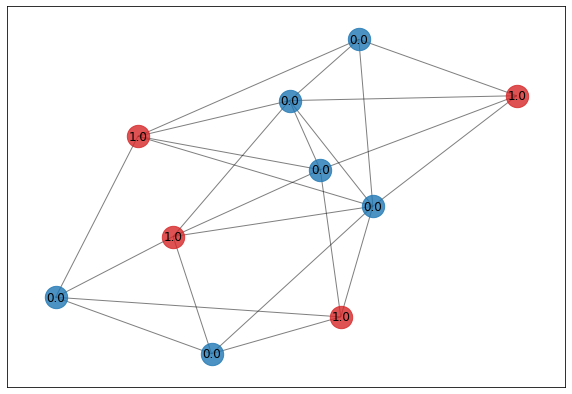

In [47]:
red = [node for node in rnd_graph.nodes() if rnd_graph.nodes()[node]['color'] == 1  ]
blue = [node for node in rnd_graph.nodes() if rnd_graph.nodes()[node]['color'] == 0  ]

plt.figure(figsize= (10,7))
pos = nx.spring_layout(rnd_graph)
nx.draw_networkx_nodes(rnd_graph,pos, nodelist= red, node_color= "tab:red",  alpha= 0.8, node_size= 500)
nx.draw_networkx_nodes(rnd_graph,pos, nodelist= blue, node_color= "tab:blue", alpha= 0.8, node_size= 500)
nx.draw_networkx_edges(rnd_graph,pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(rnd_graph, pos, config)
plt.show()

Note that the solution from the ```LeapHybridCQMSampler``` is better compared to the solution from the ```ExactCQMSolver``` in that a higher no. of nodes has been included in the set !

### Example: Graph Coloring

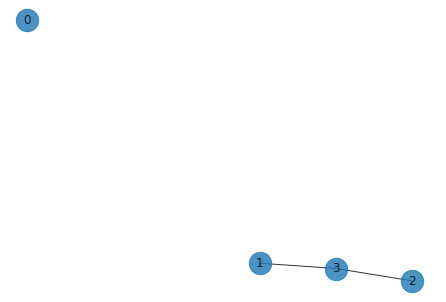

In [ ]:
from dwave_networkx.algorithms import min_vertex_color_qubo

nodes = 4
p = 0.35

rnd_graph_mc = erdos_renyi_graph(nodes, p, seed= 1904892)
nx.draw(rnd_graph_mc, with_labels= True, alpha= 0.8, node_size= 500)

In [ ]:
qm = min_vertex_color_qubo(rnd_graph_mc)

In [ ]:
qm

{((0, 0), (0, 0)): -1,
 ((0, 1), (0, 1)): -1,
 ((0, 0), (0, 1)): 2,
 ((1, 0), (1, 0)): -1,
 ((1, 1), (1, 1)): -1,
 ((1, 0), (1, 1)): 2,
 ((2, 0), (2, 0)): -1,
 ((2, 1), (2, 1)): -1,
 ((2, 0), (2, 1)): 2,
 ((3, 0), (3, 0)): -1,
 ((3, 1), (3, 1)): -1,
 ((3, 0), (3, 1)): 2,
 ((1, 0), (3, 0)): 1,
 ((1, 1), (3, 1)): 1,
 ((2, 0), (3, 0)): 1,
 ((2, 1), (3, 1)): 1}

### Example: Constrained Scheduling
Here our aim is to form a schedule such that the following constraints are :

Constraint 1: During business hours, all meetings must be attended in person at the office.

Constraint 2: During business hours, participation in meetings is mandatory.

Constraint 3: Outside business hours, meetings must be teleconferenced.

Constraint 4: Outside business hours, meetings must not exceed 30 minutes.

The aim is to use ```ConstrainedQuadraticModel``` to find all feasible solutions, such that the follwoing constraints are satisfied.


###### ref. https://docs.ocean.dwavesys.com/en/stable/examples/scheduling.html for more details


The varialbles required are $ t, v, l, p $ respectively for representing time, venue, duration and type of participation, it is clear that except for the duration $l$ , other verialbes can only take binary values. 

In [71]:
cqm_scheduling = CQM()

In [72]:
## setup the variables
t = dimod.Binary('t')
v = dimod.Binary('v')
p = dimod.Binary('p')
l = dimod.Integer('l', upper_bound= 20 )
vars = [t, v, p , l]


In [73]:
## setup the constraints for CQM
#1
cqm_scheduling.add_constraint( t - t*v == 0, label= 'constraint 1' )
#2
cqm_scheduling.add_constraint( t - t*p == 0, label= 'constraint 2' )
#3
cqm_scheduling.add_constraint( v - t*v == 0, label= 'constraint 3'  )
#4
cqm_scheduling.add_constraint( t*l - t - l <= 10, label= 'constrain 4' )
##
# cqm_scheduling.set_objective( 0*t ) ## we do not have an objective function in this case, we would just need to msample such that the constraints are satisfied !

'constrain 4'

In [74]:
# cqm_scheduling.variables,
cqm_scheduling.constraints

{'constraint 1': Eq(BinaryQuadraticModel({'t': 1.0, 'v': -0.0}, {('v', 't'): -1.0}, -0.0, 'BINARY'), 0),
 'constraint 2': Eq(BinaryQuadraticModel({'t': 1.0, 'p': -0.0}, {('p', 't'): -1.0}, -0.0, 'BINARY'), 0),
 'constraint 3': Eq(BinaryQuadraticModel({'v': 1.0, 't': -0.0}, {('t', 'v'): -1.0}, -0.0, 'BINARY'), 0),
 'constrain 4': Le(QuadraticModel({'t': -1.0, 'l': -1.0}, {('l', 't'): 1.0}, -0.0, {'t': 'BINARY', 'l': 'INTEGER'}, dtype='float64'), 10)}

In [87]:
sample_set_scheduling = ExactCQMSolver().sample_cqm(cqm_scheduling)
feasible_sol = sample_set_scheduling.filter( lambda sol : sol.is_feasible )
feasible_sol

SampleSet(rec.array([([ 0,  0,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 0,  1,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 0,  1,  1,  1], 0., 1, [ True,  True,  True,  True],  True),
           ([ 1,  0,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 1,  1,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 1,  1,  1,  1], 0., 1, [ True,  True,  True,  True],  True),
           ([ 2,  0,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 2,  1,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 2,  1,  1,  1], 0., 1, [ True,  True,  True,  True],  True),
           ([ 3,  0,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 3,  1,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 3,  1,  1,  1], 0., 1, [ True,  True,  True,  True],  True),
           ([ 4,  0,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 4

In [86]:
# sample_set_scheduling = LeapHybridCQMSampler().sample_cqm(cqm_scheduling)
# feasible_sol = sample_set_scheduling.filter( lambda sol : sol.is_feasible )
# feasible_sol

SampleSet(rec.array([([ 0,  0,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 0,  1,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 0,  1,  1,  1], 0., 1, [ True,  True,  True,  True],  True),
           ([ 1,  0,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 1,  1,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 1,  1,  1,  1], 0., 1, [ True,  True,  True,  True],  True),
           ([ 2,  0,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 2,  1,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 2,  1,  1,  1], 0., 1, [ True,  True,  True,  True],  True),
           ([ 3,  0,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 3,  1,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 3,  1,  1,  1], 0., 1, [ True,  True,  True,  True],  True),
           ([ 4,  0,  0,  0], 0., 1, [ True,  True,  True,  True],  True),
           ([ 4

### Scratch Cell

In [ ]:
graph_sample_set.to_pandas_dataframe()

,0,1,2,3,4,5,6,7,8,9,energy,is_feasible,is_satisfied,num_occurrences
0,0,0,0,0,0,0,0,0,0,0,0.0,True,True,1
1,0,1,0,0,0,0,0,0,0,0,-1.0,True,True,1
2,1,0,0,0,0,0,0,0,0,0,-1.0,True,True,1
3,1,1,0,0,0,0,0,0,0,0,-2.0,False,False,1
4,0,0,1,0,0,0,0,0,0,0,-1.0,True,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,1,1,0,1,1,1,1,1,1,1,-9.0,False,False,1
1020,0,0,1,1,1,1,1,1,1,1,-8.0,False,False,1
1021,0,1,1,1,1,1,1,1,1,1,-9.0,False,False,1
1022,1,0,1,1,1,1,1,1,1,1,-9.0,False,False,1
